In [2]:
import hopsworks
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from hsml.schema import Schema
from hsml.model_schema import ModelSchema
import joblib
import os
import torch
import seaborn as sns
import numpy as np

In [3]:
project = hopsworks.login()
fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/221335
Connected. Call `.close()` to terminate connection gracefully.


In [4]:
fg = fs.get_feature_group(name = 'finalproj', version=1)
query = fg.select(['statement', 'label']).read()

Finished: Reading data from Hopsworks, using ArrowFlight (1.32s) 


In [5]:
query.isnull().values.any()

False

In [6]:
# Encode labels
def encode_label(label: str):
    replacements = {
        'true': 0,
        'mostly-true': 2,
        'half-true': 2,
        'false': 1,
        'pants-fire': 1,
        'barely-true': 1,
        'full-flop': 1
    }
    return replacements.get(label, label)

query['label'] = query['label'].apply(encode_label)
query['label']

0      1
1      1
2      1
3      1
4      2
      ..
600    1
601    1
602    1
603    1
604    0
Name: label, Length: 605, dtype: int64

2024-01-04 20:07:59,848 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-01-04 20:07:59,853 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


<Axes: xlabel='label', ylabel='count'>

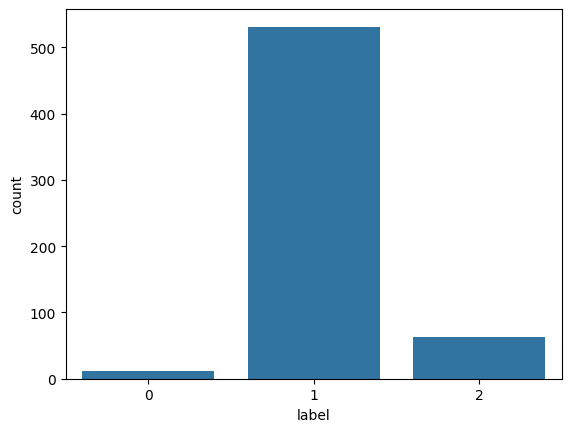

In [7]:
# Skewed distribution: need to address this
sns.countplot(x='label', data = query)

In [8]:
query['statement']

0      “Israeli Army Commander admits they handcuffed...
1      Macaulay Culkin’s “Home Alone” shopping trip t...
2      Video muestra “Palestinos cargando el cuerpo d...
3      "Los pasajeros de un avión cantan para ayudar ...
4      Gov. Tony Evers and Democrats "rejected our (I...
                             ...                        
600    Dr. Ben Carson endorsed CBD gummies to treat h...
601    Elon Musk developed “Cosmo Heater,” a product ...
602    Video shows Trump promising to pause student l...
603    El Dr. Sanjay Gupta sufrió “un atentado” por c...
604    Donald Trump “deported less, believe it or not...
Name: statement, Length: 605, dtype: object

In [9]:
# Remove punctuations 
import re
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

def process_text(sen):
    '''Cleans text data up, leaving only 2 or more char long non-stopwords composed of A-Z 
    and a-z only'''
    sentence = sen.lower()
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)
    sentence = re.sub(r'\b[a-zA-Z]\b', '', sentence)  # Improved single-character word removal
    sentence = re.sub(r'\s+', ' ', sentence)
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    sentence = pattern.sub('', sentence)
    return sentence.strip()  # Strip to remove any leading or trailing whitespace

# Assuming 'query' is a DataFrame and 'statement' is a column in it
query['statement'] = query['statement'].apply(process_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jayden/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
query['statement']

0      israeli army commander admits handcuffed coupl...
1      macaulay culkin home alone shopping trip cost ...
2      video muestra palestinos cargando el cuerpo de...
3      los pasajeros de un avi cantan para ayudar cal...
4      gov tony evers democrats rejected iowa model r...
                             ...                        
600    dr ben carson endorsed cbd gummies treat high ...
601    elon musk developed cosmo heater product would...
602    video shows trump promising pause student loan...
603    el dr sanjay gupta sufri un atentado por crear...
604    donald trump deported less believe barack obam...
Name: statement, Length: 605, dtype: object

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(query['statement'], query['label'], test_size=0.2)

In [12]:
from nltk.tokenize import word_tokenize

nltk.download('punkt')

# Tokenize all text data
def tokenize_text(text):
    return word_tokenize(text)

X_train_tokenized = X_train.apply(tokenize_text)
X_test_tokenized = X_test.apply(tokenize_text)

[nltk_data] Downloading package punkt to /Users/jayden/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [13]:
all_tokens = []
for tokens_list in X_train_tokenized:  
    all_tokens.extend(tokens_list)

vocab = set(all_tokens)
vocab_size = len(vocab) + 1

print("Vocabulary Size:", vocab_size)

word_to_index = {word: i+2 for i, word in enumerate(vocab)}
word_to_index['<PAD>'] = 0  # Padding
word_to_index['<UNK>'] = 1  # Unknown words


Vocabulary Size: 2389


In [30]:
import json
with open('indices.json', 'w') as json_file:
    json.dump(word_to_index, json_file)

In [14]:
def tokens_to_indices(tokenized_text, word_to_index):
    return [word_to_index.get(word, word_to_index['<UNK>']) for word in tokenized_text]

X_train_indices = X_train_tokenized.apply(lambda x: tokens_to_indices(x, word_to_index))
X_test_indices = X_test_tokenized.apply(lambda x: tokens_to_indices(x, word_to_index))


In [15]:
X_train_indices[0]


[1213, 2234, 1694, 1285, 1197, 726, 1942, 882, 1848, 2359, 735, 1460]

In [16]:
max_len = 100  # Or any other length suitable for your data

def pad_sequences(sequences, maxlen):
    return [seq[:maxlen] + [0]*(maxlen - len(seq)) if len(seq) < maxlen else seq[:maxlen] for seq in sequences]

X_train_padded = pad_sequences(X_train_indices, max_len)
X_test_padded = pad_sequences(X_test_indices, max_len)


In [17]:
len(X_train_padded[0])

100

In [18]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_padded, y_train)


2024-01-04 20:08:00,802 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-01-04 20:08:00,805 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


<Axes: xlabel='label', ylabel='count'>

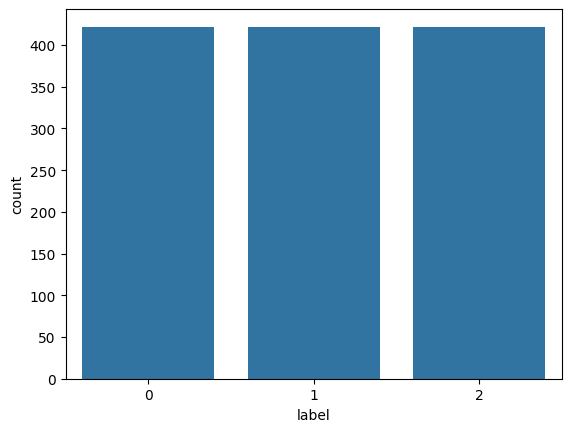

In [19]:
test = pd.DataFrame(y_train_smote)
sns.countplot(x = 'label', data = test)

In [20]:
X_train_tensor = torch.tensor(X_train_smote, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_padded, dtype=torch.long)
y_train_tensor = torch.tensor(y_train_smote.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype = torch.long)

print("X_train_tensor shape", X_train_tensor.shape)
print("X_test_tensor shape", X_test_tensor.shape)
print("y_train_tensor shape", y_train_tensor.shape)
print("y_test_tensor shape", y_test_tensor.shape)

X_train_tensor shape torch.Size([1266, 100])
X_test_tensor shape torch.Size([121, 100])
y_train_tensor shape torch.Size([1266])
y_test_tensor shape torch.Size([121])


In [21]:
from torch.utils.data import Dataset, DataLoader
import torch

class TextDataset(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = x_data
        self.y_data = y_data

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        return self.x_data[idx], self.y_data[idx]
# Create the dataset
train_dataset = TextDataset(X_train_tensor, y_train_tensor)
test_dataset = TextDataset(X_test_tensor, y_test_tensor)

# Create the DataLoader
batch_size = 32  
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)



In [22]:
def load_glove_embeddings(path):
    embeddings_dict = {}
    with open(path, 'r', encoding='utf8') as file:
        for line in file:
            values = line.split()
            word = values[0]
            vector = torch.tensor([float(val) for val in values[1:]], dtype=torch.float32)
            embeddings_dict[word] = vector
    return embeddings_dict

glove_embeddings = load_glove_embeddings('glove.6B.100d.txt')

# Determine the embedding dimension from the GloVe embeddings
embedding_dim = next(iter(glove_embeddings.values())).size(0)

# Initialize an embedding matrix
vocab_size = len(vocab) + 2
embedding_matrix = torch.zeros(vocab_size, embedding_dim)

# Create a word to index mapping for vocabulary
word_to_idx = {word: idx for idx, word in enumerate(vocab)}

# Populate the embedding matrix
for word, idx in word_to_idx.items():
    if word in glove_embeddings:
        embedding_matrix[idx] = glove_embeddings[word]
    else:
        # Handle unknown words - here using random vectors
        embedding_matrix[idx] = torch.randn(embedding_dim)



In [23]:
embedding_matrix.shape

torch.Size([2390, 100])

In [24]:
import torch.nn as nn

class LSTMClassifier(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, num_layers, num_classes, dropout=0.5):
        super(LSTMClassifier, self).__init__()
        vocab_size, embed_dim = embedding_matrix.shape

        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.embedding.weight = nn.Parameter(embedding_matrix)  # Initialize with GloVe
        self.embedding.weight.requires_grad = False  # Freeze embeddings

        # LSTM layer
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers, dropout=dropout, batch_first=True)

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        lstm_out, _ = self.lstm(x)
        x = lstm_out[:, -1, :]  # Take the output of the last time step
        x = self.fc(x)
        return x

hidden_dim = 128  # Number of features in the hidden state of the LSTM
num_layers = 2    # Number of stacked LSTM layers
num_classes = 3   # Number of output classes

model = LSTMClassifier(embedding_matrix, hidden_dim, num_layers, num_classes)


In [26]:
from sklearn.metrics import f1_score
import numpy as np
from torch import optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    total_loss = 0

    for inputs, targets in train_loader:
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f'Epoch {epoch+1}, Loss: {total_loss/len(train_loader)}')

    # Validation
    model.eval()  # Set the model to evaluation mode
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            # Collect all predictions and targets
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    # Calculate F1 score
    f1 = f1_score(all_targets, all_predictions, average='weighted')
    print(f'Epoch {epoch+1}, F1 Score: {f1:.2f}')

Epoch 1, Loss: 1.1027213662862778
Epoch 1, F1 Score: 0.85
Epoch 2, Loss: 1.0996848225593567
Epoch 2, F1 Score: 0.85
Epoch 3, Loss: 1.0999411195516586
Epoch 3, F1 Score: 0.00
Epoch 4, Loss: 1.0996710300445556
Epoch 4, F1 Score: 0.85
Epoch 5, Loss: 1.099271112680435
Epoch 5, F1 Score: 0.01
Epoch 6, Loss: 1.0992216050624848
Epoch 6, F1 Score: 0.00
Epoch 7, Loss: 1.0992949217557908
Epoch 7, F1 Score: 0.85
Epoch 8, Loss: 1.0990879774093627
Epoch 8, F1 Score: 0.01
Epoch 9, Loss: 1.098936927318573
Epoch 9, F1 Score: 0.85
Epoch 10, Loss: 1.0989816427230834
Epoch 10, F1 Score: 0.01


In [29]:
import os
import joblib
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

# Directory for the Linear Regression model
lstm_model_dir = "lstm"
if not os.path.isdir(lstm_model_dir):
    os.mkdir(lstm_model_dir)

# Save the Linear Regression model
joblib.dump(model, lstm_model_dir + "/lstm.pkl")

# Assuming X_train and y_train are your features and labels
input_schema = Schema(X_train_tensor.numpy())
output_schema = Schema(y_train_tensor.numpy())
model_schema = ModelSchema(input_schema, output_schema)

# Get an object for the model registry
mr = project.get_model_registry()

# Create and save the Linear Regression model
lstm_model_entry = mr.python.create_model(
    name="lstm_model",
    description="lstm Model",
    # Add any relevant metrics or additional info
)

lstm_model_entry.save(lstm_model_dir)


Connected. Call `.close()` to terminate connection gracefully.


Uploading: 100.000%|██████████| 1961915/1961915 elapsed<00:02 remaining<00:003.02it/s]
Model export complete: 100%|██████████| 6/6 [00:09<00:00,  1.53s/it]                   

Model created, explore it at https://c.app.hopsworks.ai:443/p/221335/models/lstm_model/1


Model(name: 'lstm_model', version: 1)